# Imports

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import numpy as np
from tensorflow.keras import layers
import time

# Dataset

In [23]:
(train_images,train_labels),(_,_)=tf.keras.datasets.fashion_mnist.load_data()

In [24]:
# checking the shape of our images
train_images.shape

(60000, 28, 28)

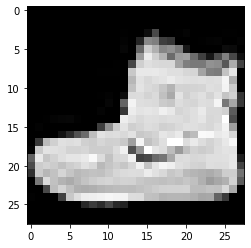

In [25]:
# looking at one image
plt.imshow(train_images[0,:,:],cmap='gray')

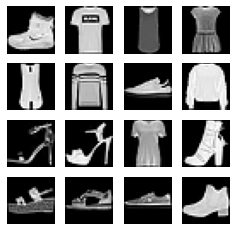

In [26]:
fig = plt.figure(figsize=(4,4))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(train_images[i, :, :], cmap='gray')
  plt.axis('off')

In [27]:
#reshaping 
train_images=train_images.reshape(60000,28,28,1).astype(np.float32)
# change the range of pixel values (between -1 to 1)
train_images=(train_images-127.5)/127.5

In [28]:
# creating the dataset
BATCH_SIZE=32
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

# Generator

In [29]:
# generator from DCGAN architecture
def gen_model():

  model=tf.keras.Sequential()
  
  model.add(layers.Dense(7*7*256,use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7,7,256)))

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),use_bias=False,padding='same'))
  assert model.output_shape== (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape==(None,14,14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
  assert model.output_shape==(None,28,28,1)

  return model

In [30]:
generator=gen_model()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)        

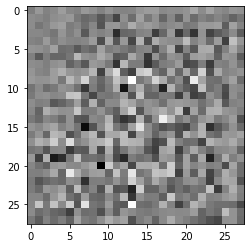

In [31]:
# trying our generator which is still not trained
noise=tf.random.normal([1,100])
generated_images=generator(noise,training=False)
plt.imshow(generated_images[0,:,:,0],cmap='gray')

# Discriminator

In [32]:
def disc_model():
  model=tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1,activation='sigmoid'))

  return model



In [33]:
discriminator=disc_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [34]:
# let's classify one image generated by our generator
predictions=discriminator(generated_images)
print(predictions)

tf.Tensor([[0.50017637]], shape=(1, 1), dtype=float32)


# GAN

In [35]:
gan=tf.keras.models.Sequential([generator,discriminator])

# Compile the model

In [36]:
optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer)
discriminator.trainable=False
gan.compile(loss='binary_crossentropy',optimizer=optimizer)

# Saving Images

In [39]:
seed=tf.random.normal([16,100])

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(f'image_at_epoch_{epoch}.png')
  plt.show()

In [ ]:
import os
cwd = os.getcwd()

# Training the GAN

Time for epoch 1 is 44.81927561759949 sec


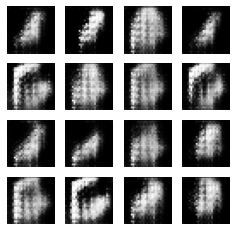

Time for epoch 2 is 42.8731632232666 sec


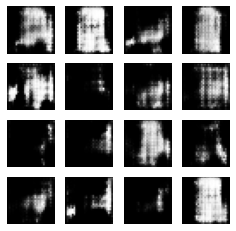

Time for epoch 3 is 43.26736330986023 sec


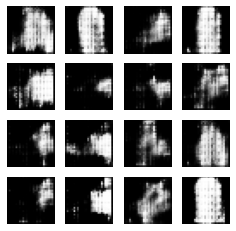

Time for epoch 4 is 44.06787943840027 sec


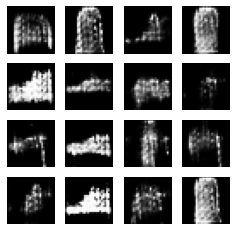

Time for epoch 5 is 42.43646740913391 sec


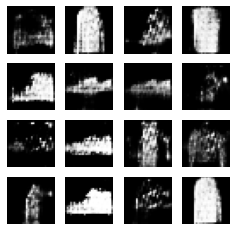

In [40]:
def train_gan(gan,dataset,batch_size,n_epochs=5):
  generator,discriminator=gan.layers

  for epoch in range(n_epochs):
    start = time.time()

    for X_batch in dataset:

      # training the discriminator
      noise= tf.random.normal([batch_size,100])
      generated_images=generator(noise)
      fake_real_images=tf.concat([generated_images,X_batch],axis=0)
      y_disc=tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
      discriminator.trainable=True
      discriminator.train_on_batch(fake_real_images,y_disc)

      # training the generator
      noise=tf.random.normal([batch_size,100])
      y_gen=tf.constant([[1.]]*batch_size)
      discriminator.trainable=False
      gan.train_on_batch(noise,y_gen)

    print (f'Time for epoch {epoch + 1} is {time.time()-start} sec')
    generate_and_save_images(generator, epoch,seed)

train_gan(gan,train_dataset,BATCH_SIZE)



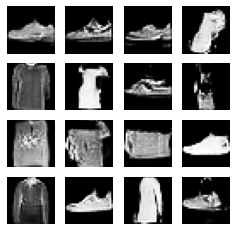

In [ ]:
# showing some images
seed=tf.random.normal([16,100])
generated_images = generator(seed, training=False)

fig = plt.figure(figsize=(4,4))

for i in range(generated_images.shape[0]):
  plt.subplot(4, 4, i+1)
  plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')

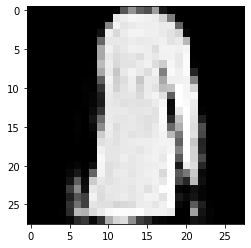

In [ ]:
plt.imshow(generated_images[14, :, :, 0] * 127.5 + 127.5, cmap='gray')